In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import tensorflow as tf
import spacy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re
from datetime import date
import scienceplots
from datetime import date
from catboost import Pool, CatBoostRegressor
import xgboost as xgb
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from itertools import product
from xgboost import plot_importance

rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline


/Users/echo/opt/miniconda3/envs/sna/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [45]:
items = pd.read_csv("./items.csv")
shops = pd.read_csv("./shops.csv")
item_categories = pd.read_csv("./item_categories.csv")
train = pd.read_csv("./sales_train.csv")
test = pd.read_csv("./test.csv")
_item_categories = pd.read_csv("./_item_categories.csv")

In [4]:
items

item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id  
0                    40  
1                    76  
2                    40  
3                    40  
4                    40  
...                 ...  
22165                31  
22166                54  
22167                49  
22168                62  
22169                69  

[22170 rows x 3 columns]

In [5]:
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [6]:
item_categories.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [46]:
_item_categories.head()

item_category_name  item_category_id   category_1  category_2
0  PC - Headsets/Headphones                 0   headphones  headphones
1         Accessories - PS2                 1  accessories         ps2
2         Accessories - PS3                 2  accessories         ps3
3         Accessories - PS4                 3  accessories         ps4
4         Accessories - PSP                 4  accessories         psp

In [7]:
train

date  date_block_num  shop_id  item_id  item_price  \
0        02.01.2013               0       59    22154      999.00   
1        03.01.2013               0       25     2552      899.00   
2        05.01.2013               0       25     2552      899.00   
3        06.01.2013               0       25     2554     1709.05   
4        15.01.2013               0       25     2555     1099.00   
...             ...             ...      ...      ...         ...   
2935844  10.10.2015              33       25     7409      299.00   
2935845  09.10.2015              33       25     7460      299.00   
2935846  14.10.2015              33       25     7459      349.00   
2935847  22.10.2015              33       25     7440      299.00   
2935848  03.10.2015              33       25     7460      299.00   

         item_cnt_day  
0                 1.0  
1                 1.0  
2                -1.0  
3                 1.0  
4                 1.0  
...               ...  
2935844           1.0  
2935845           1.0  
2935846           1.0  
2935847           1.0  
2935848           1.0  

[2935849 rows x 6 columns]

In [8]:
test

ID  shop_id  item_id
0            0        5     5037
1            1        5     5320
2            2        5     5233
3            3        5     5232
4            4        5     5268
...        ...      ...      ...
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969

[214200 rows x 3 columns]

In [9]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")


items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



Preprocessing

train

In [10]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


format: date

In [11]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

Anomalies in item_price column

In [12]:
train[train['item_price'] < 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683 2013-05-15               4       32     2973        -1.0           1.0

In [13]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
453034 2013-05-15               4       25     2973      1249.5           1.0
469026 2013-05-15               4       46     2973      1249.5           1.0
469951 2013-05-15               4       45     2973      1249.0           1.0
484683 2013-05-15               4       32     2973        -1.0           1.0

In [14]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()


In [15]:
train[train['item_price'] < 0]

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []

Anomalies in item_cnt_day column

In [16]:
negative_train = train[train['item_cnt_day'] < 0]

In [17]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [18]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [19]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

Select shops that appear in test set

In [20]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")


The number of shops in train data: 60
The number of shops in test data: 42


In [21]:
train = train[train['shop_id'].isin(test['shop_id'].unique().tolist())]
train


date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0       2013-01-02               0       59    22154      999.00           1.0
1       2013-01-03               0       25     2552      899.00           1.0
2       2013-01-05               0       25     2552      899.00           0.0
3       2013-01-06               0       25     2554     1709.05           1.0
4       2013-01-15               0       25     2555     1099.00           1.0
...            ...             ...      ...      ...         ...           ...
2935844 2015-10-10              33       25     7409      299.00           1.0
2935845 2015-10-09              33       25     7460      299.00           1.0
2935846 2015-10-14              33       25     7459      349.00           1.0
2935847 2015-10-22              33       25     7440      299.00           1.0
2935848 2015-10-03              33       25     7460      299.00           1.0

[2413246 rows x 6 columns]

Date aggregation

In [22]:
train = pd.merge(train, 
                 train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index(),
                 on=['date_block_num', 'shop_id', 'item_id'],
                 how='left')
train


date  date_block_num  shop_id  item_id  item_price  \
0       2013-01-02               0       59    22154      999.00   
1       2013-01-03               0       25     2552      899.00   
2       2013-01-05               0       25     2552      899.00   
3       2013-01-06               0       25     2554     1709.05   
4       2013-01-15               0       25     2555     1099.00   
...            ...             ...      ...      ...         ...   
2413241 2015-10-10              33       25     7409      299.00   
2413242 2015-10-09              33       25     7460      299.00   
2413243 2015-10-14              33       25     7459      349.00   
2413244 2015-10-22              33       25     7440      299.00   
2413245 2015-10-03              33       25     7460      299.00   

         item_cnt_day  item_cnt_month  
0                 1.0             1.0  
1                 1.0             1.0  
2                 0.0             1.0  
3                 1.0             1.0  
4                 1.0             1.0  
...               ...             ...  
2413241           1.0             3.0  
2413242           1.0             3.0  
2413243           1.0             1.0  
2413244           1.0             1.0  
2413245           1.0             3.0  

[2413246 rows x 7 columns]

test

In [23]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


384

In [24]:
train_g = train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index()
train_g


date_block_num  shop_id  item_id  item_cnt_month
0                     0        2       27             1.0
1                     0        2       33             1.0
2                     0        2      317             1.0
3                     0        2      438             1.0
4                     0        2      471             2.0
...                 ...      ...      ...             ...
1323790              33       59    22087             6.0
1323791              33       59    22088             2.0
1323792              33       59    22091             1.0
1323793              33       59    22100             1.0
1323794              33       59    22102             1.0

[1323795 rows x 4 columns]

In [ ]:
_items = pd.merge(train, items, how='outer', on=['item_id','item_id'])

Visualization

Can different months effect on the amount of product?    
number of months: "date_block_num"    
amount of products: ["item_cnt_day"].sum()

In [25]:
train.groupby(by="date_block_num")["item_cnt_day"].sum()

date_block_num
0      92193.0
1      90716.0
2     114905.0
3      84189.0
4      85763.0
5     103566.0
6      94986.0
7     101691.0
8     107569.0
9      98640.0
10    105871.0
11    149597.0
12     93532.0
13     89569.0
14     93257.0
15     77525.0
16     78795.0
17     79062.0
18     74499.0
19     84010.0
20     81474.0
21     81071.0
22     96693.0
23    139631.0
24     91676.0
25     72293.0
26     71656.0
27     71979.0
28     67005.0
29     60220.0
30     60084.0
31     65280.0
32     72365.0
33     65385.0
Name: item_cnt_day, dtype: float64

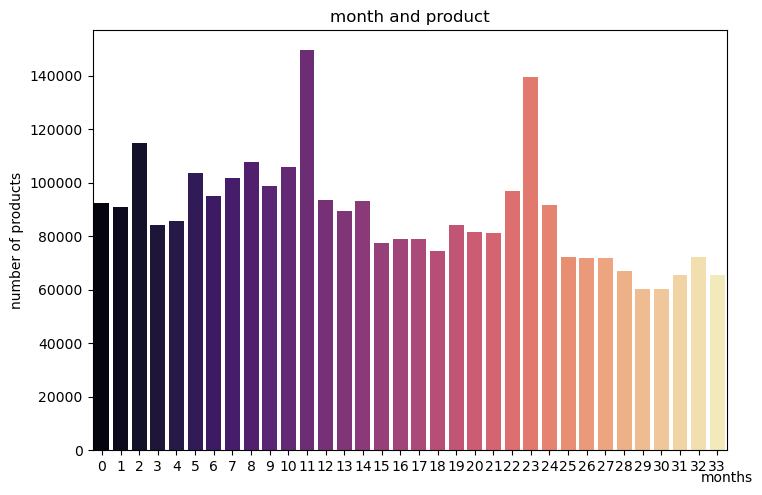

In [26]:
plt.figure(figsize=(18, 12))
plt.xticks(size=1)
ax1 = plt.subplot(2,2,1)
sns.barplot(ax=ax1, 
            palette="magma",
            y=train.groupby(by="date_block_num")["item_cnt_day"].sum().unique(),
            x=np.arange(34)
           )
ax1.set(ylabel="number of products", xlabel="months", title="month and product")
ax1.xaxis.set_label_coords(1, -0.05)

How the diffferent date affect same shop's product amount?    
same shop: "shop_id"   
different days:"date"   
amount of prodcuts:"item_cnt_day"

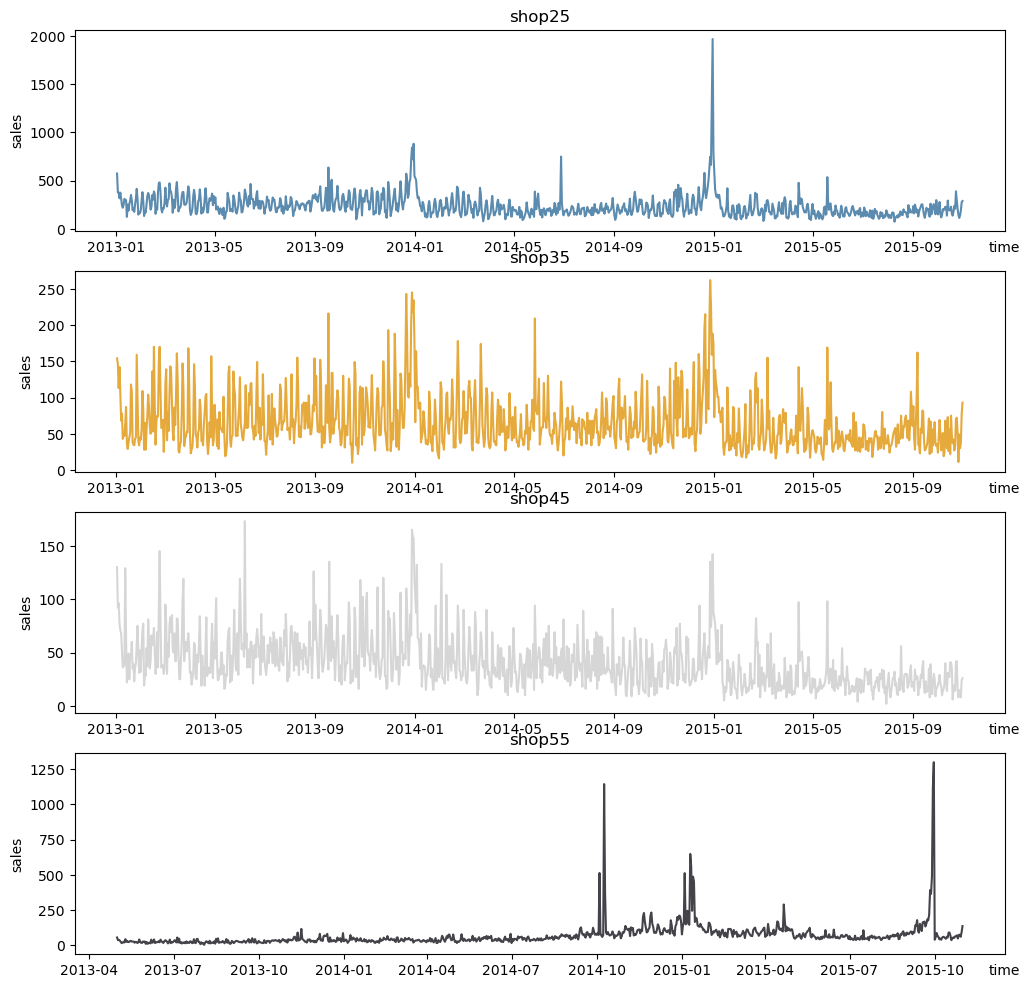

In [27]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))
sns.lineplot(ax=axs[0], data=train[train["shop_id"] == 25].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#5B8BAF")
axs[0].set(xlabel="time", ylabel="sales", title="shop25")
axs[0].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[1], data=train[train["shop_id"] == 35].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#E5A93C")
axs[1].set(xlabel="time", ylabel="sales", title="shop35")
axs[1].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[2], data=train[train["shop_id"] == 45].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#D7D6D7")
axs[2].set(xlabel="time", ylabel="sales", title="shop45")
axs[2].xaxis.set_label_coords(1, -0.05)
sns.lineplot(ax=axs[3], data=train[train["shop_id"] == 55].groupby(by=["date"]).sum(), 
             x="date", y="item_cnt_day", color="#444349")
axs[3].set(xlabel="time", ylabel="sales", title="shop55")
axs[3].xaxis.set_label_coords(1, -0.05)


Different product categories and sales      
#1 number of different product categories    
#2 percentage of sales on different product categories      
#3 average sales of different product categories

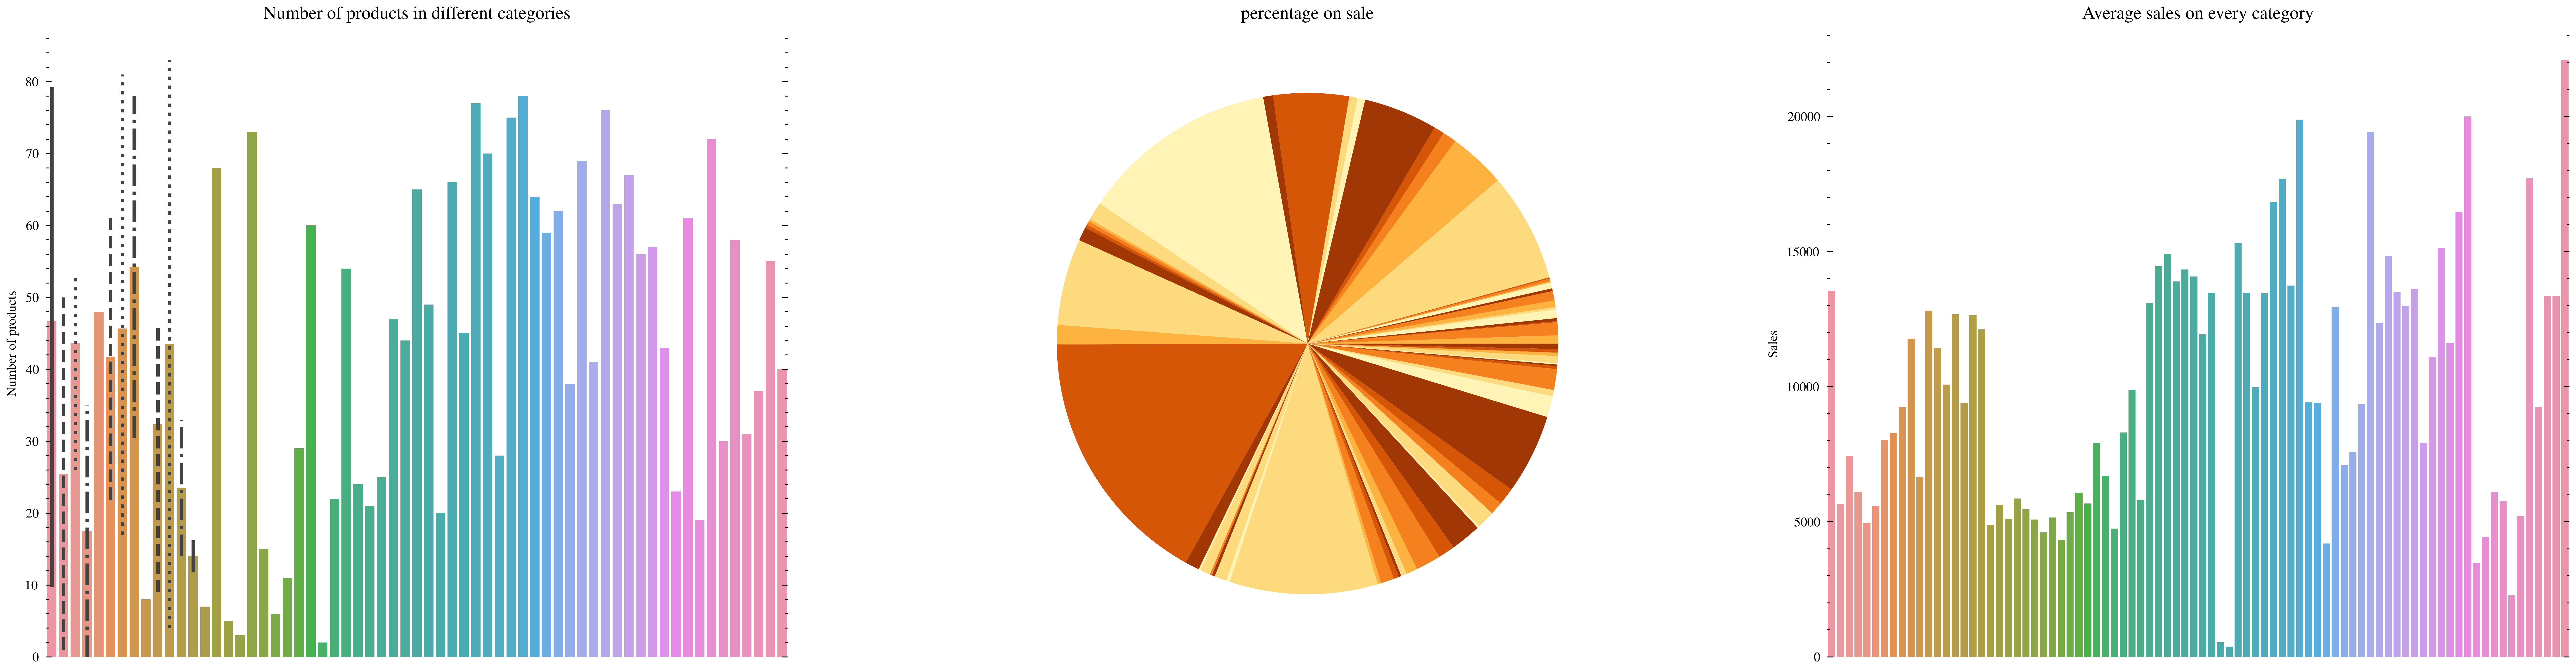

In [59]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plt.style.use(['science','ieee'])
sns.despine(bottom = True, left = True)
sns.barplot(ax=axs[0],
            x=items.groupby(by="item_category_id")["item_id"].count(), 
            y=np.arange(84), 
            # palette="Spectral"
           )
axs[0].axes.xaxis.set_visible(False)
axs[0].set(xlabel="Category", ylabel="Number of products", title="Number of products in different categories")
axs[0].xaxis.set_label_coords(1, -0.05)

type_sum = _items.groupby(by="item_category_id")["item_cnt_day"].sum()
axs[1].pie(type_sum / type_sum.sum(), 
           colors=sns.color_palette("YlOrBr"), 
          #  autopct='%.0f%%'
)
axs[1].set(title="percentage on sale")

sns.barplot(ax=axs[2], 
               x=items.groupby(by="item_category_id")["item_id"].mean().index, 
               y=items.groupby(by="item_category_id")["item_id"].mean(),
            #    palette="Spectral"
              )
axs[2].axes.xaxis.set_visible(False)
axs[2].set(xlabel="Category", ylabel="Sales", title="Average sales on every category")
axs[2].xaxis.set_label_coords(1, -0.05)


City and shop

In [29]:
def extract_feature(text_col):
    features = list()
    len_lst = list()
    nlp = spacy.load("ru_core_news_lg")
    fail_count = 0
    
    for i in tqdm(range(text_col.shape[0])):
        one_feature = list()
        tokens = nlp (text_col[i])
        for token in tokens:
            try:
                one_feature.append(ru_model.get_vector(token.text))
            except:
                continue
        if len(one_feature) > 0:
            one_feature = np.stack(one_feature).flatten()
        else:
            one_feature = np.zeros(300)
            fail_count += 1
        features.append(one_feature)
        len_lst.append(one_feature.shape[0])
        
    med = int(pd.Series(len_lst).max())
    print(f"Max: {med}")
    feature_tp = list()
    for item in features:
        if item.shape[0] < med:
            item = np.concatenate([item, np.zeros(med - item.shape[0])])
        else:
            item = item[:med]
        feature_tp.append(item)
    
    print(f"Failed: {fail_count}")
    features = np.stack(feature_tp)
    return features


In [30]:
def encoding_cate(ser, num):
    ser_df = ser.value_counts().to_frame('count').reset_index()
    ser_df = ser_df.loc[ser_df['count'] > num, 'index']
    print(f"The number of classes: {ser_df.shape[0] + 1}")
    ser_df = pd.DataFrame({"cate": ser_df.tolist(), "index": list(range(ser_df.shape[0], 0, -1))})
    return ser.to_frame('cate').merge(ser_df, on='cate', how='left').fillna(0)['index'].astype(int)

In [31]:
shop_name = shops['shop_name'].str.split(pat=' ', n=2)
def remove_stopping_words(lst):
    new_lst = list()
    for i in lst:
        i = i.strip(',?!"()')
        i = re.sub('"', '', i)
        i = re.sub('\(', '', i)
        if i != "":
            new_lst.append(i)
    return new_lst

shop_name_split = shop_name.apply(remove_stopping_words)
shop_city = shop_name_split.apply(lambda x: x[0])
shop_info = shop_name_split.apply(lambda x: x[1])

In [32]:
shops['city'] = encoding_cate(shop_city, 0)
shops['info'] = encoding_cate(shop_info, 1)
shops = shops.drop(columns=['shop_name'])
shops.head()

The number of classes: 32
The number of classes: 7


shop_id  city  info
0        0    30     2
1        1    30     6
2        2    10     6
3        3     2     4
4        4     3     6

In [33]:
_shops = pd.read_csv("./_shops.csv")

In [34]:
shops_count =  _shops.groupby("city")["shop_id"].count().reset_index()
shops_count["city"]

0            Adygea
1        Balashikha
2            Chekov
3            Kaluga
4             Kazan
5           Khimski
6           Kolomna
7       Krasnoyarsk
8            Moscow
9         Mytishchi
10       N.Novgorod
11      Novosibirsk
12             Omsk
13           Online
14         Outbound
15           Rostov
16              SPb
17           Samara
18    Sergiev Posad
19           Surgut
20            Tomsk
21           Tyumen
22              Ufa
23          Vologda
24         Volzhsky
25         Voronezh
26          Yakutsk
27        Yaroslavl
28        Zhukovsky
Name: city, dtype: object

In [35]:
_train = pd.merge(train, _shops, how='outer', on=['shop_id','shop_id'])

In [36]:
_train

date  date_block_num  shop_id  item_id  item_price  \
0       2013-01-02             0.0       59  22154.0       999.0   
1       2013-01-10             0.0       59  22151.0       399.0   
2       2013-01-04             0.0       59   5603.0       699.0   
3       2013-01-19             0.0       59   5587.0       199.0   
4       2013-01-31             0.0       59   5613.0      5571.0   
...            ...             ...      ...      ...         ...   
2413259        NaT             NaN       33      NaN         NaN   
2413260        NaT             NaN       40      NaN         NaN   
2413261        NaT             NaN       43      NaN         NaN   
2413262        NaT             NaN       51      NaN         NaN   
2413263        NaT             NaN       54      NaN         NaN   

         item_cnt_day  item_cnt_month  \
0                 1.0             1.0   
1                 1.0             2.0   
2                 1.0             1.0   
3                 2.0             2.0   
4                 1.0             1.0   
...               ...             ...   
2413259           NaN             NaN   
2413260           NaN             NaN   
2413261           NaN             NaN   
2413262           NaN             NaN   
2413263           NaN             NaN   

                                                shop_name       city  \
0                     Yaroslavl shopping center "Altair""  Yaroslavl   
1                     Yaroslavl shopping center "Altair""  Yaroslavl   
2                     Yaroslavl shopping center "Altair""  Yaroslavl   
3                     Yaroslavl shopping center "Altair""  Yaroslavl   
4                     Yaroslavl shopping center "Altair""  Yaroslavl   
...                                                   ...        ...   
2413259                              Mytishchi SEC "XL-3"  Mytishchi   
2413260  Rostov-on-Don SEC "Megacenter Horizon" Ostrovnoy     Rostov   
2413261                                 SPb TC "Sennaya""        SPb   
2413262            Tyumen shopping center "Zeleny Bereg""     Tyumen   
2413263                    Khimki shopping center "Mega""    Khimski   

        shop_kind shop_brand  
0              sc     altair  
1              sc     altair  
2              sc     altair  
3              sc     altair  
4              sc     altair  
...           ...        ...  
2413259       sec         xl  
2413260       sec       mega  
2413261        tc    sennaya  
2413262        sc     zeleny  
2413263        sc       maga  

[2413264 rows x 11 columns]

In [37]:
cities_count = _train.groupby(by=["city"])["item_cnt_day"].mean().reset_index()
cities_count["city"]

0            Adygea
1        Balashikha
2            Chekov
3            Kaluga
4             Kazan
5           Khimski
6           Kolomna
7       Krasnoyarsk
8            Moscow
9         Mytishchi
10       N.Novgorod
11      Novosibirsk
12             Omsk
13           Online
14         Outbound
15           Rostov
16              SPb
17           Samara
18    Sergiev Posad
19           Surgut
20            Tomsk
21           Tyumen
22              Ufa
23          Vologda
24         Volzhsky
25         Voronezh
26          Yakutsk
27        Yaroslavl
28        Zhukovsky
Name: city, dtype: object

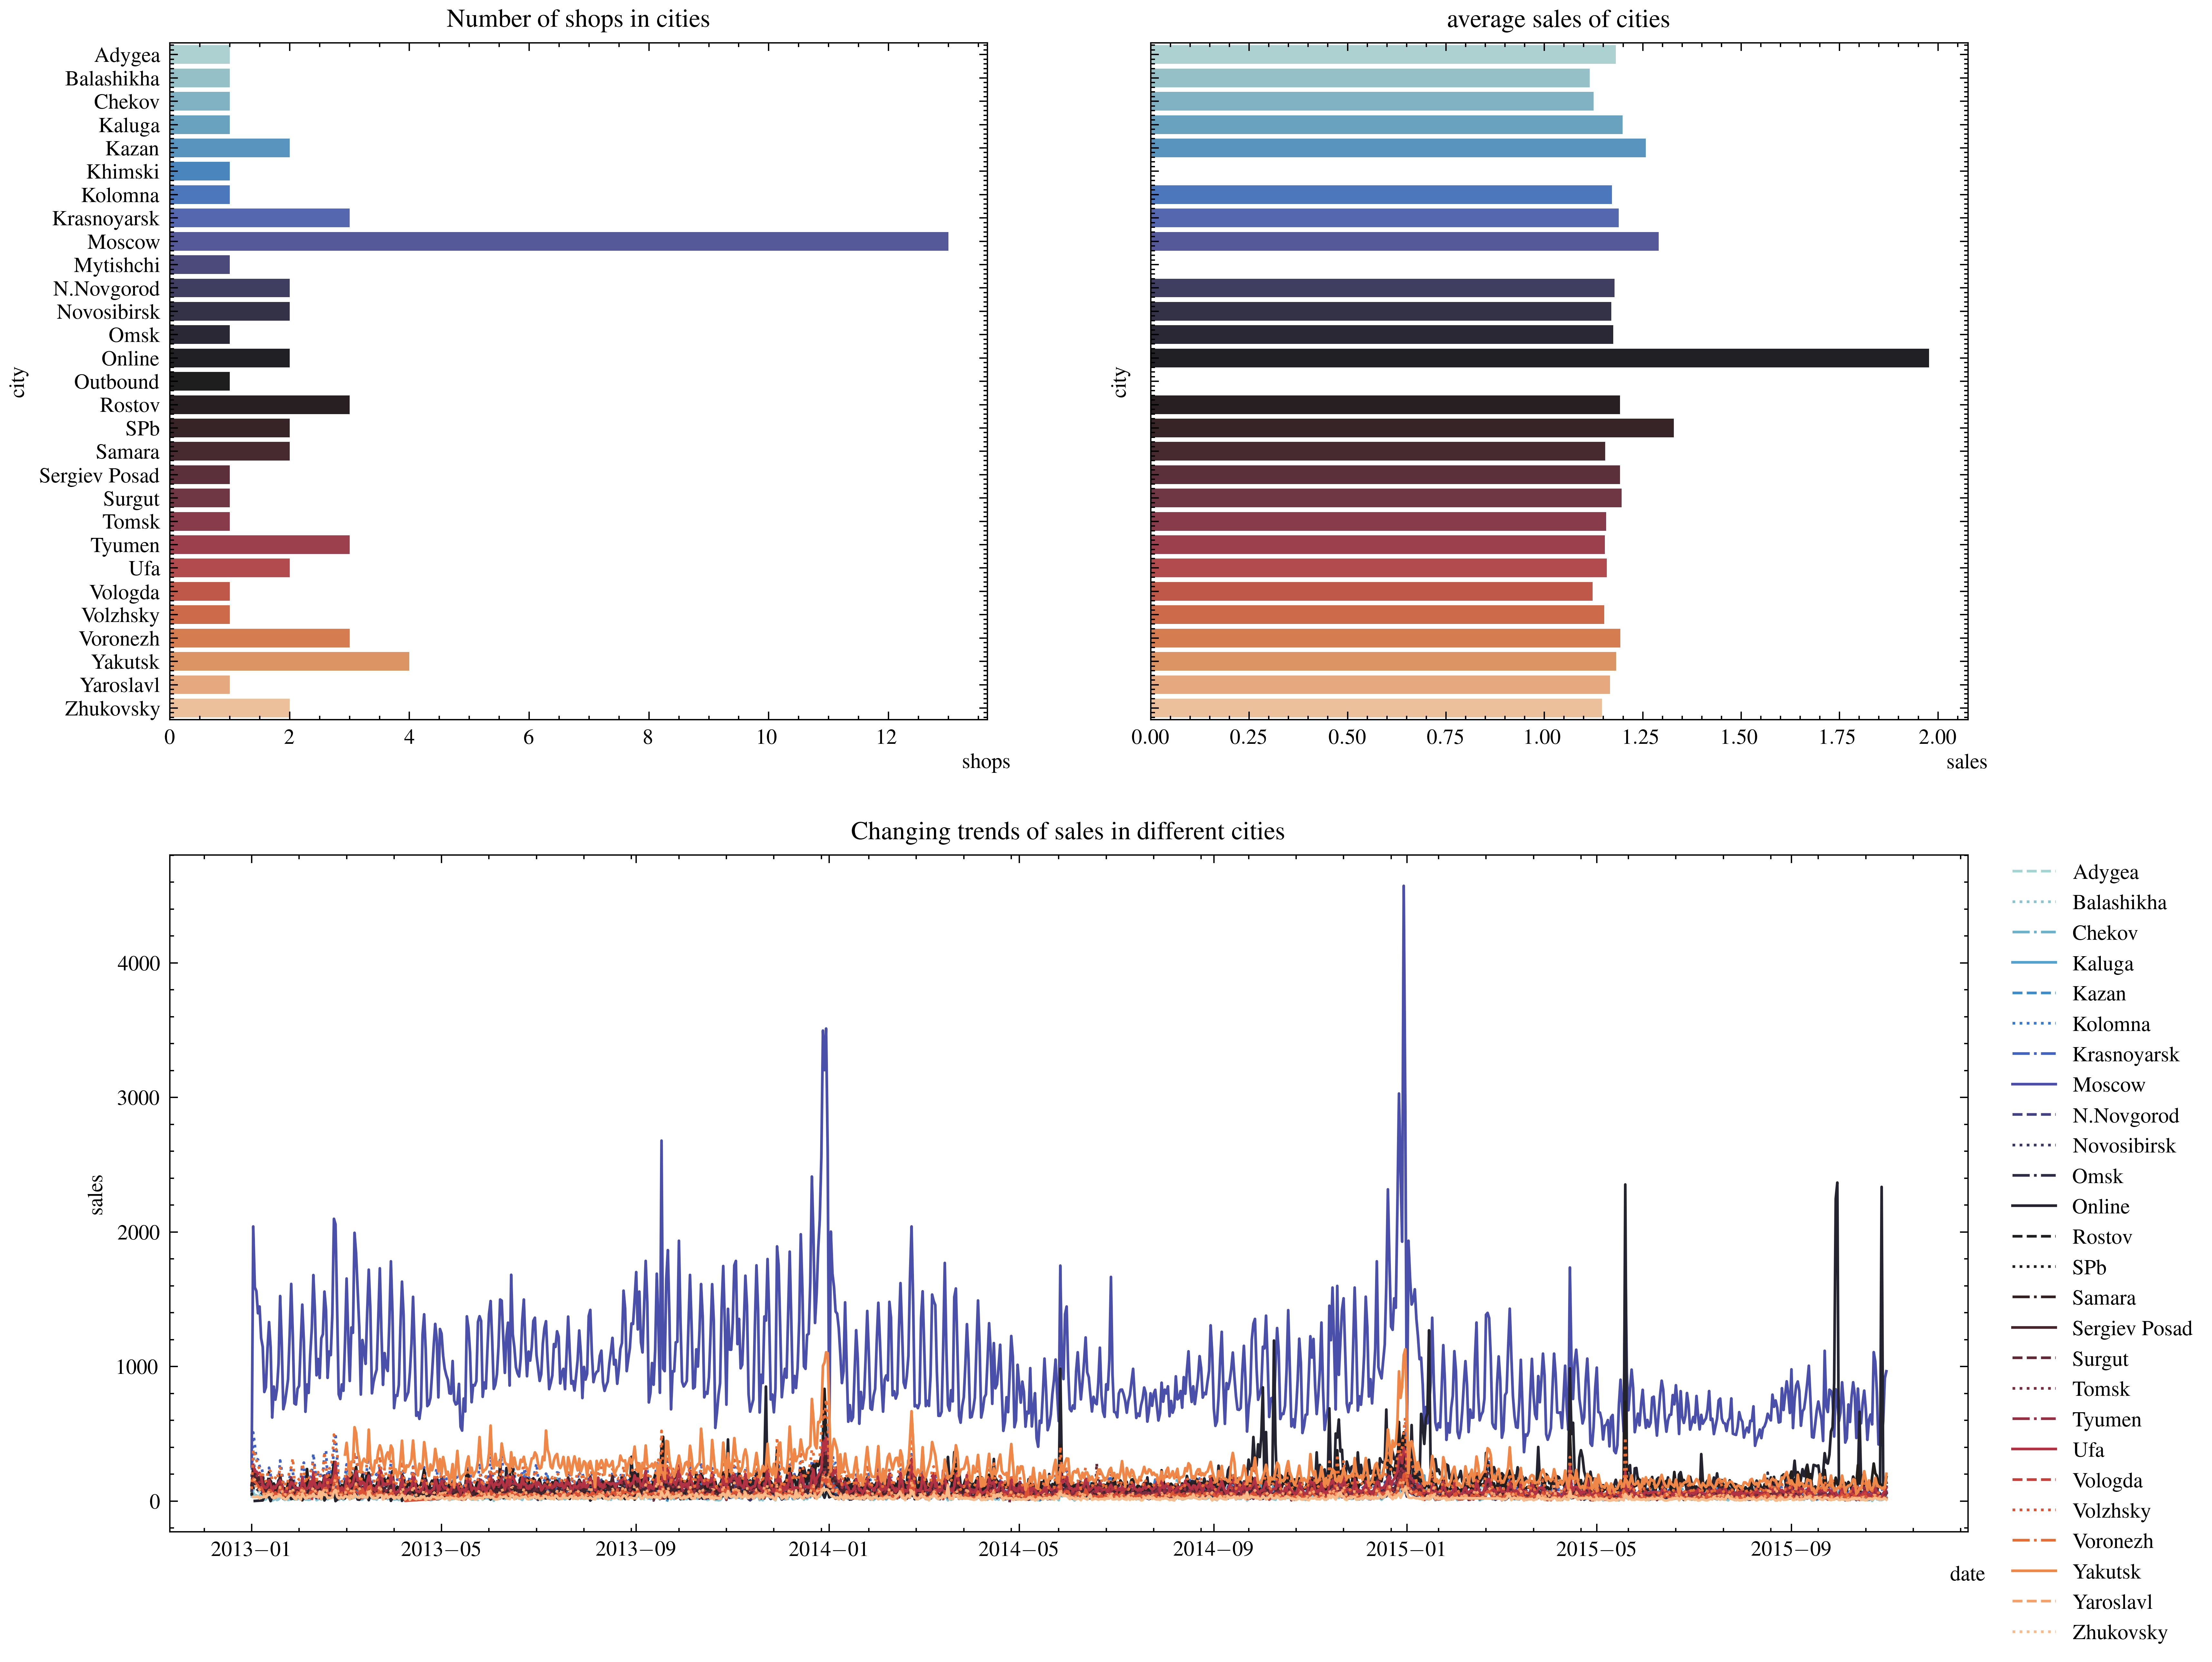

In [38]:
plt.figure(figsize=(12, 10))
ax1 = plt.subplot(2,2,1)
sns.barplot(ax=ax1, 
            palette="icefire",
            y=shops_count["city"],
            x=shops_count["shop_id"]
           )
ax1.set(ylabel="city", xlabel="shops", title="Number of shops in cities")
ax1.xaxis.set_label_coords(1, -0.05)
ax2 = plt.subplot(2,2,2)
sns.barplot(ax=ax2, 
            palette="icefire",
            y=cities_count["city"], 
            x=cities_count["item_cnt_day"]
           )
ax2.set(ylabel="city", xlabel="sales", title="average sales of cities", yticklabels=[])
ax2.xaxis.set_label_coords(1, -0.05)
ax3 = plt.subplot(2,1,2)
sns.lineplot(ax=ax3,
             palette="icefire",
             data=_train.groupby(by=["city", "date"])["item_cnt_day"].sum().reset_index(),
             x="date",
             y="item_cnt_day",
             hue="city"
            )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax3.set(ylabel="sales", xlabel="date", title="Changing trends of sales in different cities")
ax3.xaxis.set_label_coords(1, -0.05)


Price of products

In [40]:
_items

date  date_block_num  shop_id  item_id  item_price  \
0       2013-01-02             0.0     59.0    22154       999.0   
1       2013-01-23             0.0     24.0    22154       999.0   
2       2013-01-02             0.0     25.0    22154       999.0   
3       2013-01-03             0.0     25.0    22154       999.0   
4       2013-01-20             0.0     25.0    22154       999.0   
...            ...             ...      ...      ...         ...   
2414406        NaT             NaN      NaN    22028         NaN   
2414407        NaT             NaN      NaN    22035         NaN   
2414408        NaT             NaN      NaN    22062         NaN   
2414409        NaT             NaN      NaN    22137         NaN   
2414410        NaT             NaN      NaN    22138         NaN   

         item_cnt_day  item_cnt_month                    item_name  \
0                 1.0             1.0            ЯВЛЕНИЕ 2012 (BD)   
1                 1.0             1.0            ЯВЛЕНИЕ 2012 (BD)   
2                 1.0             5.0            ЯВЛЕНИЕ 2012 (BD)   
3                 1.0             5.0            ЯВЛЕНИЕ 2012 (BD)   
4                 1.0             5.0            ЯВЛЕНИЕ 2012 (BD)   
...               ...             ...                          ...   
2414406           NaN             NaN                  ЭКСПЕРИМЕНТ   
2414407           NaN             NaN          ЭЛВИН И БУРУНДУКИ 2   
2414408           NaN             NaN            ЭПОХА ГЕРОЕВ (BD)   
2414409           NaN             NaN                     Я, РОБОТ   
2414410           NaN             NaN  Я, РОБОТ (2DVD+BD) жел.бокс   

         item_category_id  
0                      37  
1                      37  
2                      37  
3                      37  
4                      37  
...                   ...  
2414406                40  
2414407                40  
2414408                37  
2414409                40  
2414410                40  

[2414411 rows x 9 columns]

In [47]:
item_s = pd.merge(_item_categories, _items, how='outer', on=['item_category_id','item_category_id'])

In [48]:
item_s

item_category_name  item_category_id   category_1  category_2  \
0        PC - Headsets/Headphones                 0   headphones  headphones   
1        PC - Headsets/Headphones                 0   headphones  headphones   
2        PC - Headsets/Headphones                 0   headphones  headphones   
3        PC - Headsets/Headphones                 0   headphones  headphones   
4               Accessories - PS2                 1  accessories         ps2   
...                           ...               ...          ...         ...   
2414406                 Batteries                83    batteries   batteries   
2414407                 Batteries                83    batteries   batteries   
2414408                 Batteries                83    batteries   batteries   
2414409                 Batteries                83    batteries   batteries   
2414410                 Batteries                83    batteries   batteries   

              date  date_block_num  shop_id  item_id  item_price  \
0       2013-01-10             0.0     25.0    16257       148.0   
1       2013-04-02             3.0     38.0    16256        22.4   
2              NaT             NaN      NaN     5441         NaN   
3              NaT             NaN      NaN    16255         NaN   
4       2013-01-10             0.0     45.0     5606       148.0   
...            ...             ...      ...      ...         ...   
2414406 2013-07-21             6.0      4.0    22093       150.0   
2414407 2013-07-19             6.0      2.0    22099        40.0   
2414408 2013-11-20            10.0     16.0    22099        40.0   
2414409 2013-12-11            11.0     10.0    22099        23.0   
2414410 2013-12-11            11.0     10.0    22098         7.0   

         item_cnt_day  item_cnt_month  \
0                 1.0             1.0   
1                 1.0             1.0   
2                 NaN             NaN   
3                 NaN             NaN   
4                 1.0             1.0   
...               ...             ...   
2414406           1.0             1.0   
2414407           1.0             1.0   
2414408           1.0             1.0   
2414409           1.0             1.0   
2414410           1.0             1.0   

                                                 item_name  
0                             Наушники RITMIX RH-124 Black  
1                                   Наушники RITMIX RH-120  
2        PC: Гарнитура HyperX Cloud Core игровая стерео...  
3                              Наушники PHILIPS SBC HC8680  
4        PS2: Карта памяти 8 Мб черная (Memory Card 8Mb...  
...                                                    ...  
2414406       Элемент питания GP 13A (LR20) - Блистер 2 шт  
2414407  Элемент питания СТАРТ ZT 15A (LR6) - Блистер 2 шт  
2414408  Элемент питания СТАРТ ZT 15A (LR6) - Блистер 2 шт  
2414409  Элемент питания СТАРТ ZT 15A (LR6) - Блистер 2 шт  
2414410                   Элемент питания КОСМОС LR03 2*BL  

[2414411 rows x 12 columns]

In [49]:
item_s.groupby(by="item_category_name")["item_price"].describe()

count         mean          std  \
item_category_name                                                            
Accessories - PS2                             1.0   148.000000          NaN   
Accessories - PS3                         14825.0  2271.496841  1172.090299   
Accessories - PS4                         21298.0  2130.189597  1455.224390   
Accessories - PSP                          1807.0   565.752031   491.382841   
Accessories - PSVita                       5821.0   855.504231   748.979521   
...                                           ...          ...          ...   
Programs - For home and office (Digital)   3746.0  1544.734347  1711.924513   
Programs - MAC (Digital)                     56.0  3403.571429  1858.811574   
Pure media (spire)                          526.0   192.372624   103.110823   
Service                                    7896.0  1095.233258   834.131611   
Tickets (Digital)                          1574.0  1342.868043   679.761365   

                                             min     25%          50%     75%  \
item_category_name                                                              
Accessories - PS2                         148.00   148.0   148.000000   148.0   
Accessories - PS3                         148.00  1490.0  2390.000000  2590.0   
Accessories - PS4                         122.59   599.0  2190.000000  3190.0   
Accessories - PSP                          22.00   299.0   299.000000   999.0   
Accessories - PSVita                       28.00   399.0   699.000000  1098.0   
...                                          ...     ...          ...     ...   
Programs - For home and office (Digital)   99.00   600.0  1180.000000  1700.0   
Programs - MAC (Digital)                  900.00  2780.0  2780.000000  3648.0   
Pure media (spire)                         79.00   149.0   149.000000   199.0   
Service                                     9.00   500.0   999.000000  1499.5   
Tickets (Digital)                         600.00   900.0  1267.083333  1300.0   

                                                 max  
item_category_name                                    
Accessories - PS2                           148.0000  
Accessories - PS3                          9990.0000  
Accessories - PS4                          7490.0000  
Accessories - PSP                          2590.0000  
Accessories - PSVita                       3490.0000  
...                                              ...  
Programs - For home and office (Digital)  27900.0000  
Programs - MAC (Digital)                   8790.0000  
Pure media (spire)                          599.0000  
Service                                   16790.0000  
Tickets (Digital)                          3507.8125  

[84 rows x 8 columns]

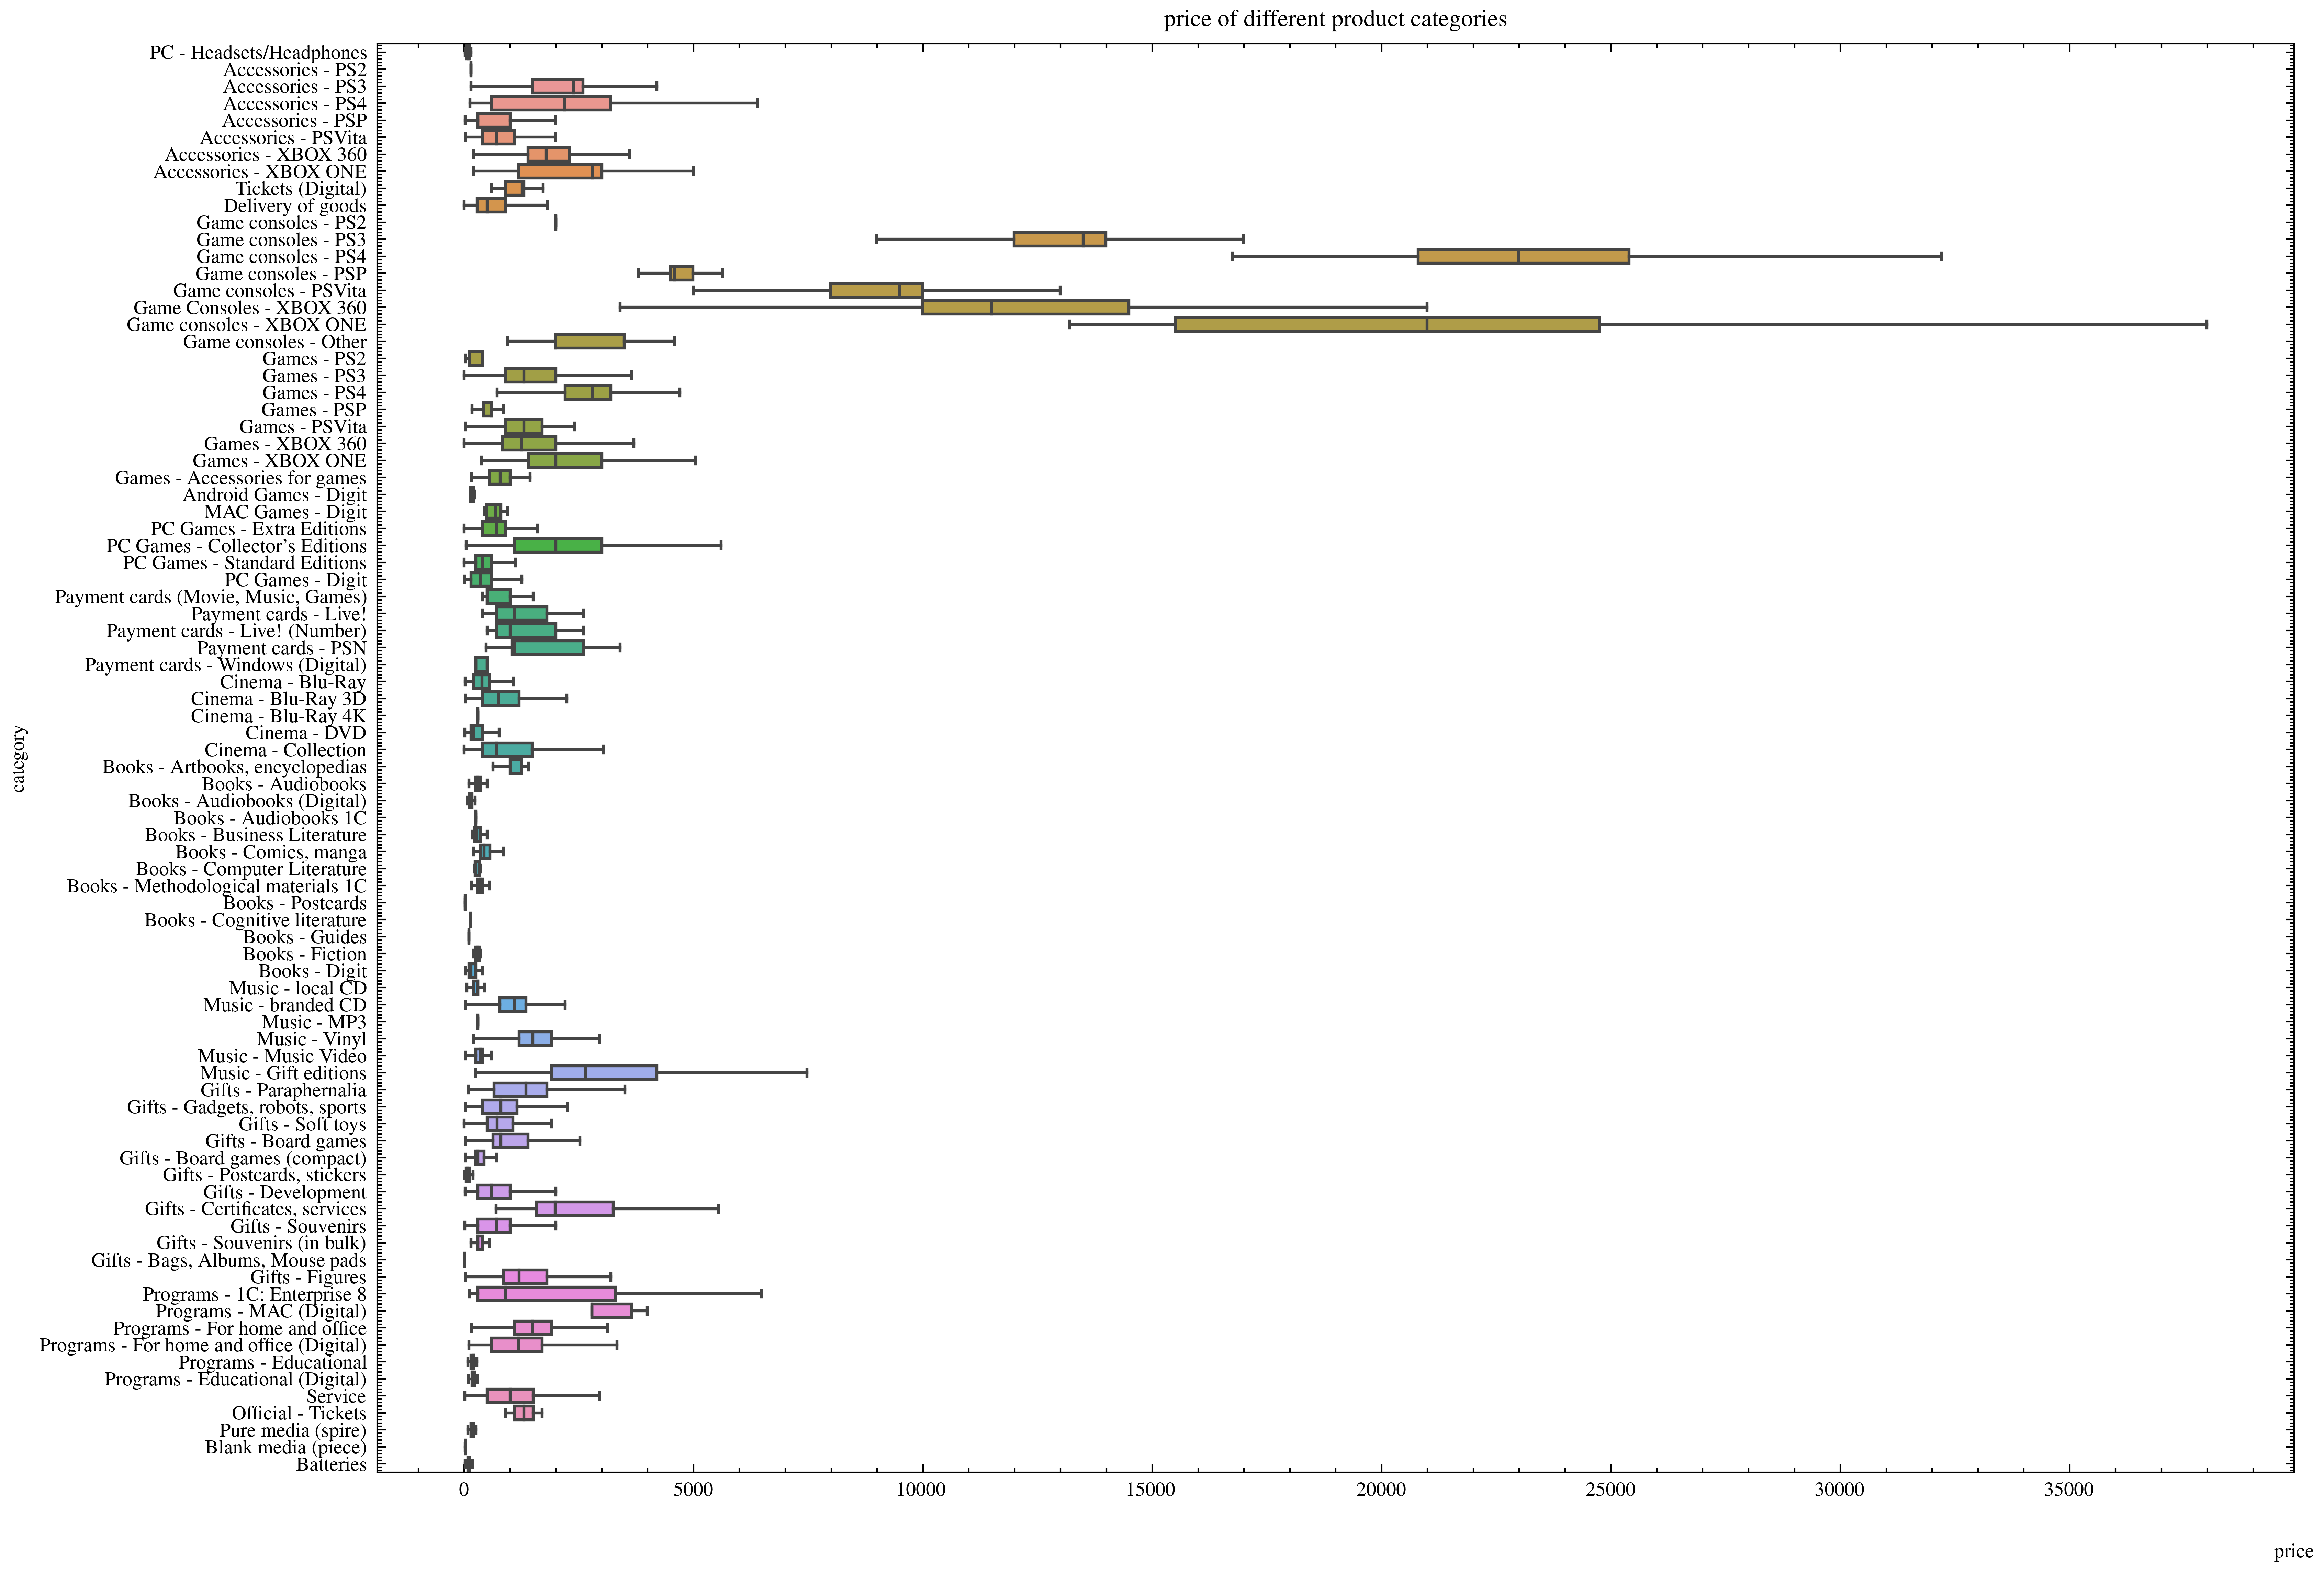

In [54]:
fig, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(x="item_price", y="item_category_name", data=item_s, showfliers=False)
ax.set(xlabel="price", ylabel="category", title="price of different product categories")
ax.xaxis.set_label_coords(1, -0.05)
plt.style.use(['science','ieee'])
plt.show()